In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
df2 = pd.read_csv('Second_dataset_rul.csv').drop(['Unnamed: 0', 'timestamp'], axis=1)
df2 =  df2[:5000]
df2.head()
X = df2.drop('rul', axis=1)
y = df2['rul']
df2.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,rul
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,285.916667
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,285.900000
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,285.883333
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,285.866667
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,285.850000


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test   = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(X_test.shape)

(4000, 50)
(1000, 50)


In [4]:
from sklearn.tree import DecisionTreeRegressor

def decision_tree(X_train, y_train, X_test):
  dt = DecisionTreeRegressor(max_depth=5)
  model = dt.fit(X_train, y_train)

  y_pred = dt.predict(X_test)

  return model, y_pred

In [5]:
from sklearn.ensemble import GradientBoostingRegressor

def gradient_boost(X_train, y_train, X_test):
  gb = GradientBoostingRegressor(max_depth=5)
  model = gb.fit(X_train, y_train)

  y_pred = gb.predict(X_test)

  return model, y_pred

In [6]:
from mapie.regression import MapieRegressor

def conformal_prediction(model, a, X_train, y_train, X_test):
  mapie = MapieRegressor(estimator=model)
  mapie_reg = mapie.fit(X_train, y_train)
  y_pred, y_pis = mapie_reg.predict(X_test, alpha=a)

  return y_pred, y_pis

In [7]:
import matplotlib.pyplot as plt

def plot_without_cp(y_test, y_pred):
  x = np.arange(1,len(y_pred)+1)

  plt.figure(figsize=(18,6))

  plt.plot(x[0:100],y_pred[0:100])
  plt.plot(x[0:100],y_test[0:100])
  plt.xlabel('First 100th sample')
  plt.ylabel('RUL')
  plt.title('Predictive maintenance RUL of first 100 samples')
  plt.legend(["prediction","true"])
  plt.grid(True)
  plt.show()

In [8]:
def plot_with_cp(y_test, y_pred, y_pis, confidence):
  x = np.arange(1,len(y_pred)+1)

  plt.figure(figsize=(18,6))

  plt.plot(x[0:100],y_pred[0:100])
  plt.plot(x[0:100],y_test[0:100])

  #plt.plot(x[0:100],y_pis[:,0][0:100])
  #plt.plot(x[0:100],y_pis[:,1][0:100])

  plt.fill_between(x[0:100], y_pis[:,0][0:100].flatten(), y_pis[:,1][0:100].flatten(), alpha=0.2, color='tab:green')

  plt.xlabel('First 100 sample')
  plt.ylabel('RUL')
  plt.title('Predictive maintenance RUL of first 100th samples with confidence of ' + confidence +'%')
  plt.legend(["prediction","true",confidence + "% confidence interval"])
  plt.grid(True)
  plt.show()

In [9]:
dt_model, y_pred = decision_tree(X_train, y_train, X_test)

In [10]:
y_pred_dt, y_pis_dt = conformal_prediction(dt_model,0.1, X_train, y_train, X_test)

In [11]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_dt)

0.9907326162319733

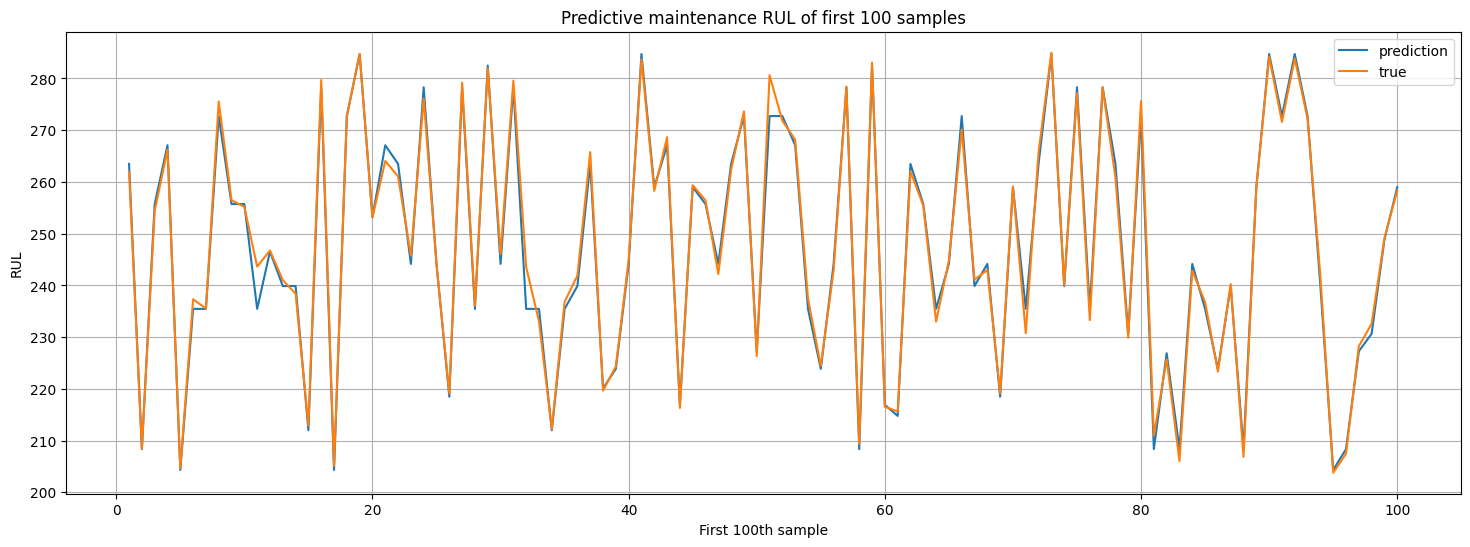

In [12]:
plot_without_cp(y_test, y_pred_dt)

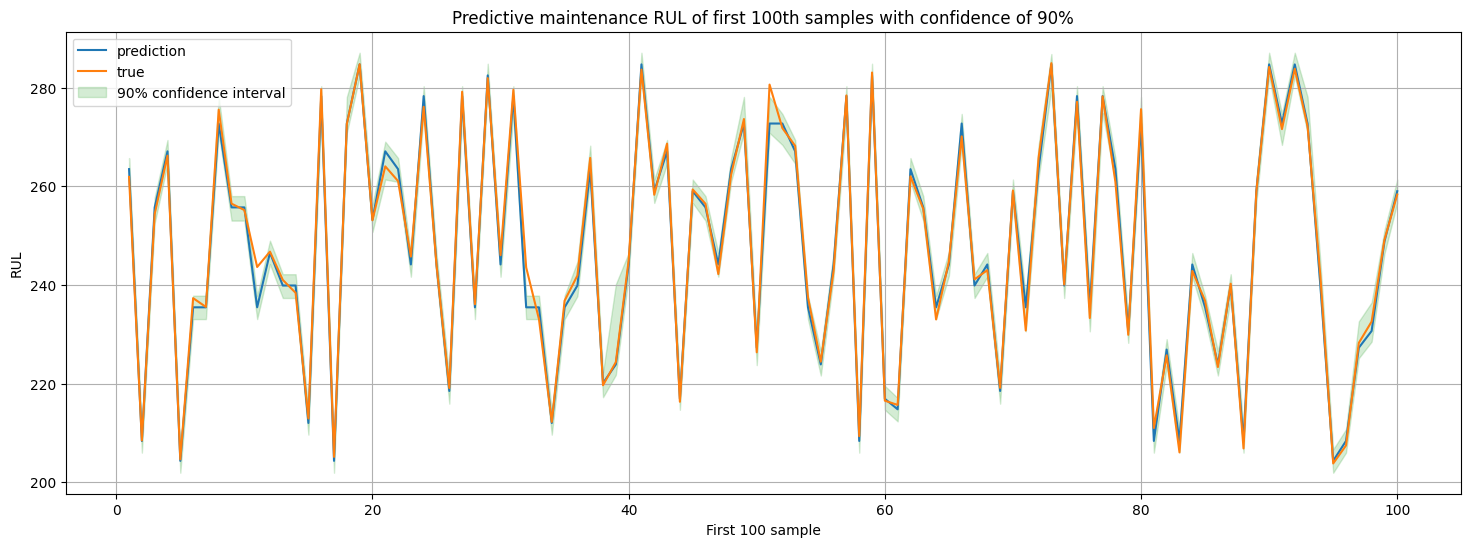

In [13]:
plot_with_cp(y_test, y_pred_dt, y_pis_dt, "90")

In [14]:
gb_model, y_pred = gradient_boost(X_train, y_train, X_test)

In [18]:
y_pred_gb, y_pis_gb = conformal_prediction(gb_model,0.1, X_train, y_train, X_test)

In [19]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_gb)

0.996864465592536

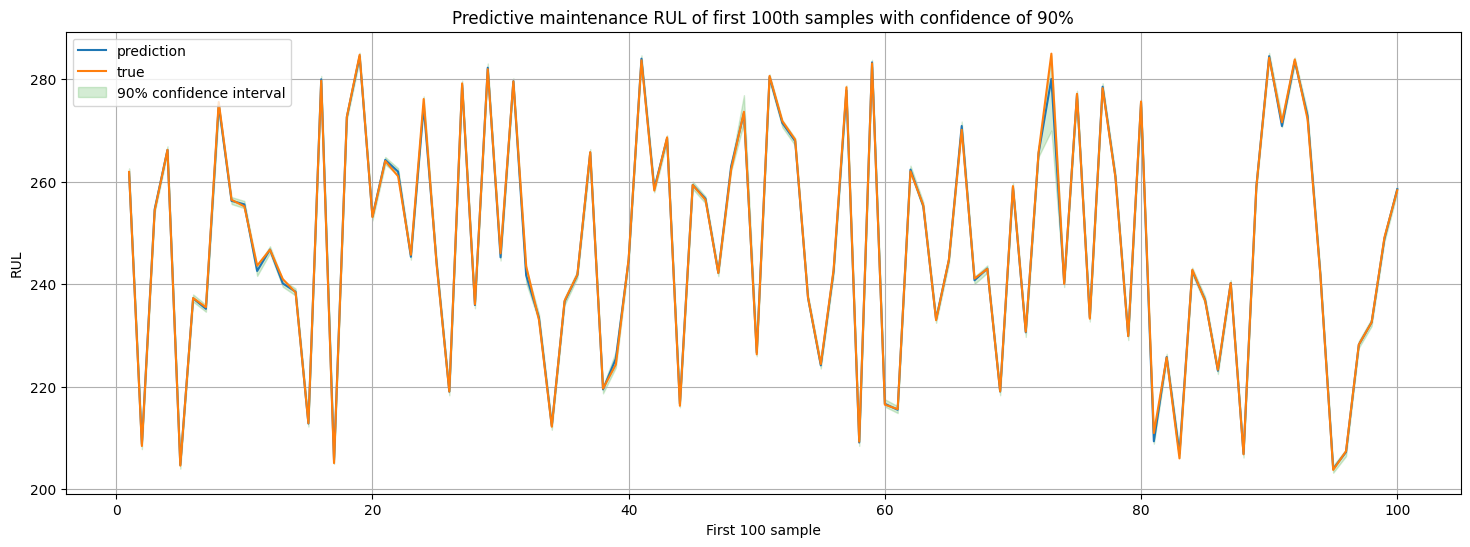

In [20]:
plot_with_cp(y_test, y_pred_gb, y_pis_gb, "90")

### 2nd Dataset 

In [23]:
df3 = pd.read_csv('Test_Data_CSV.csv')#.drop(['Unnamed: 0', 'timestamp'], axis=1)
df3[['Dust']] = df3[['Dust']].apply(lambda x: pd.factorize(x)[0])
X = df3.drop('RUL', axis=1)
y = df3['RUL']
df3.head()

,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL
0,1,0.271267,52.281993,0.1,236.428943,0,58.9
1,1,0.361690,54.986671,0.2,236.428943,0,58.8
2,1,0.000000,55.424786,0.3,236.428943,0,58.7
3,1,2.622251,55.524146,0.4,236.428943,0,58.6
4,1,3.888165,55.852018,0.5,236.428943,0,58.5


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test   = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(X_test.shape)

(31531, 6)
(7883, 6)


In [25]:
dt_model, y_pred = decision_tree(X_train, y_train, X_test)

In [26]:
y_pred_dt, y_pis_dt = conformal_prediction(dt_model,0.1, X_train, y_train, X_test)

In [27]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_dt)

0.9556187870549712

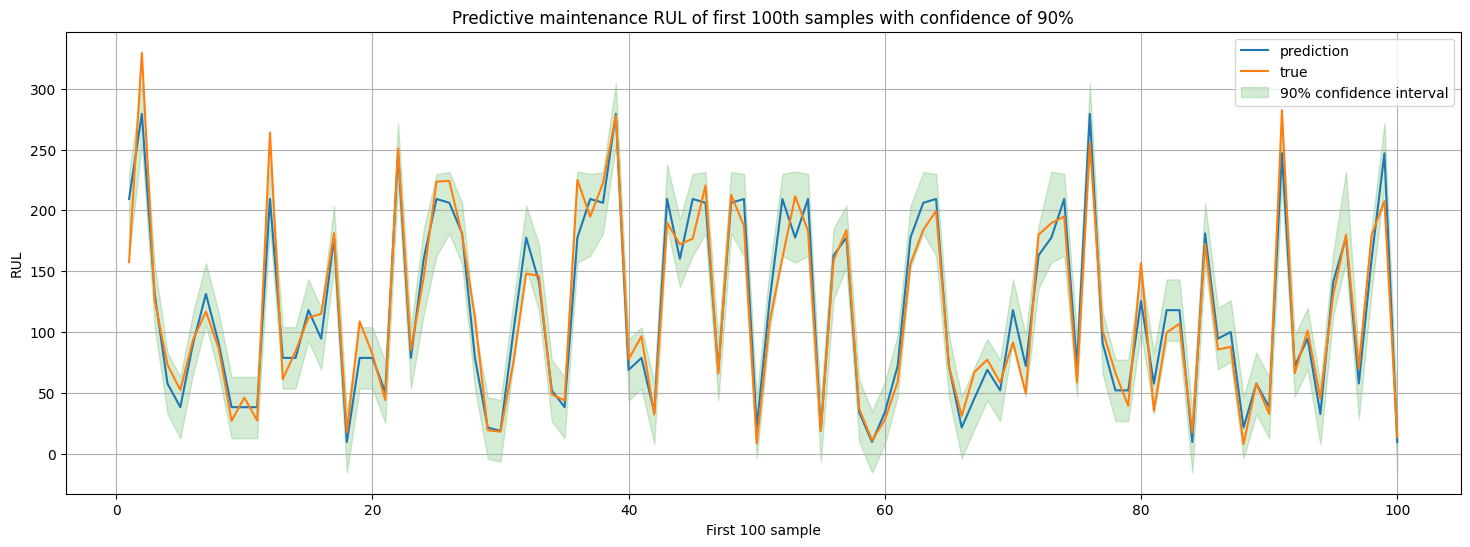

In [28]:
plot_with_cp(y_test, y_pred_dt, y_pis_dt, "90")

In [29]:
gb_model, y_pred = gradient_boost(X_train, y_train, X_test)
y_pred_gb, y_pis_gb = conformal_prediction(gb_model,0.1, X_train, y_train, X_test)

In [30]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_gb)

0.9980819876151393

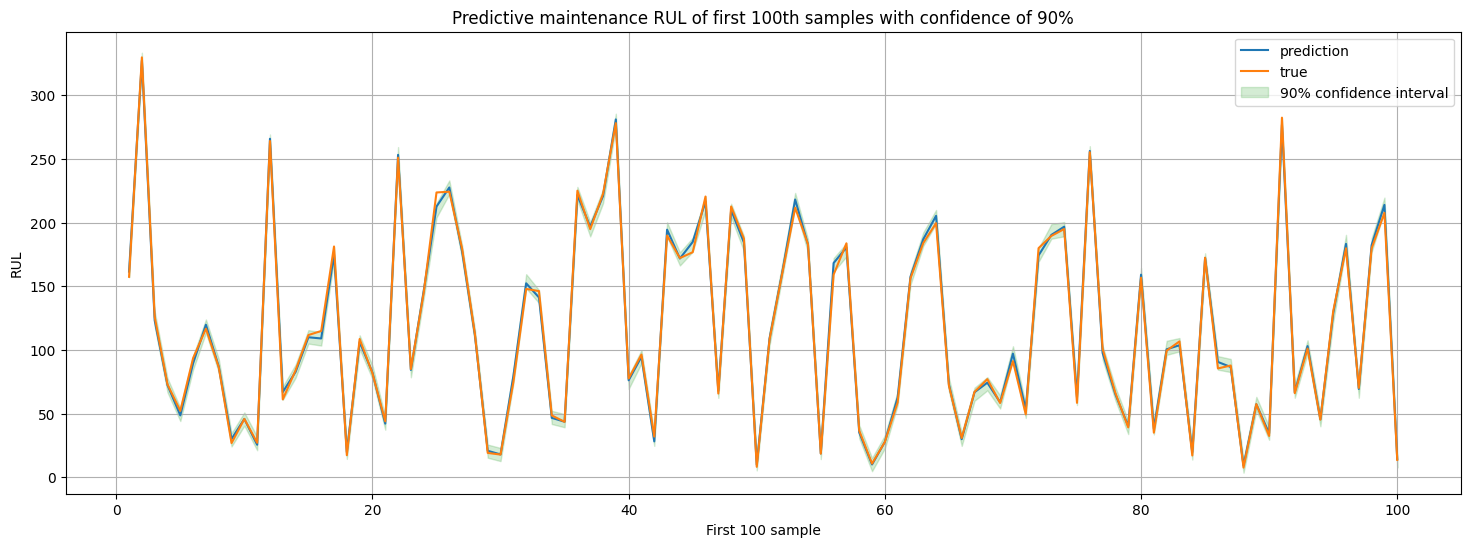

In [31]:
plot_with_cp(y_test, y_pred_gb, y_pis_gb, "90")

# LSTM

In [32]:
df2 = pd.read_csv('Second_dataset_rul.csv').drop(['Unnamed: 0', 'timestamp'], axis=1)
df2.head()
X = df2.drop('rul', axis=1)
y = df2['rul']
df2.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,rul
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,285.916667
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,285.900000
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,285.883333
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,285.866667
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,285.850000


In [34]:
train_data, test_data = train_test_split(df2, test_size=0.2) #random_state=42, stratify=df2['rul'])

In [35]:
test_data.shape
train_data.shape

(133152, 51)

In [36]:
features_col_name = df2.columns[:-1]
target_col_name = df2.columns[-1]

In [37]:
X_train = train_data.copy()
X_test = test_data.copy()

In [38]:
X_train.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,rul
104004,2.497859,48.56771,51.08507,42.968750,631.3657,82.19507,14.06973,15.37905,15.14757,15.08247,...,37.760410,42.187500,37.326389,37.905094,43.692130,42.534720,78.1250,47.453705,188.3681,400.600000
72153,2.508681,46.26736,51.17187,42.491318,633.1019,80.47691,13.61400,15.66117,15.26331,14.97396,...,33.854164,36.979164,37.905090,37.615740,38.773148,40.509260,123.2639,50.636574,208.6227,93.950000
91247,2.449653,49.34896,52.99479,44.053818,631.8287,84.26401,13.46933,15.90712,15.76968,15.08247,...,36.458330,44.010410,38.773150,39.641205,40.219906,41.666670,114.8727,66.840280,248.5532,613.216667
109602,2.466377,48.39410,48.43750,41.232635,640.5093,73.78667,13.52720,15.70457,14.98843,14.82205,...,36.718750,39.583330,39.351850,40.798610,41.666670,42.534720,125.8681,47.743057,160.5903,307.300000
4760,2.460474,51.73611,52.25694,44.704860,638.7732,73.58556,13.59954,16.16030,15.69734,15.12587,...,34.114582,43.229160,48.900460,47.743060,41.087960,38.773148,153.6458,68.576390,202.2569,206.583333


In [39]:
sc=MinMaxScaler()
X_train[features_col_name] = sc.fit_transform(X_train[features_col_name])
X_test[features_col_name] = sc.transform(X_test[features_col_name])

In [40]:
#function for features
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])), columns=id_df.columns)
    # id_df=df_zeros.append(id_df,ignore_index=True)
    id_df = pd.concat([df_zeros, id_df], ignore_index=True)

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# function to generate labels
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])), columns= id_df.columns)
    # id_df=df_zeros.append(id_df,ignore_index=True)
    id_df = pd.concat([df_zeros, id_df], ignore_index=True)

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [41]:
# timestamp or window size
seq_length=50
seq_cols=features_col_name

In [42]:
X_Train=gen_sequence(X_train, seq_length, seq_cols)
print(X_Train.shape)
# generate y_train
y_train=gen_label(X_train, seq_length, seq_cols, label='rul')
print(y_train.shape)

(133151, 50, 50)
(133151,)


In [43]:
X_Test=gen_sequence(X_test, seq_length, seq_cols)
print(X_Test.shape)
# generate y_train
y_test=gen_label(X_test, 50, seq_cols,'rul')
print(y_test.shape)

(33288, 50, 50)
(33288,)


In [44]:
nb_features =X_Train.shape[2]
timestamp=seq_length

model = Sequential()

model.add(LSTM(
         input_shape=(timestamp, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           60400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 90,651
Trainable params: 90,651
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.fit(X_Train, y_train, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Epoch 1/10
633/633 [==============================] - 147s 219ms/step - loss: -6958.7817 - accuracy: 3.9528e-05 - val_loss: -11837.2119 - val_accuracy: 0.0000e+00
Epoch 2/10
506/633 [======================>.......] - ETA: 28s - loss: -15538.4170 - accuracy: 3.9526e-05

KeyboardInterrupt: 

In [ ]:
# training metrics
scores = model.evaluate(X_Train, y_train, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

In [ ]:
y_pred=model.predict(X_Test)